In [64]:
import os
import pandas as pd
import ydata_profiling as pdp
import datetime
import numpy as np
import plotly.graph_objects as go

# 環境設定

In [2]:
DATA_PATH = "./data"

# 関数定義

In [92]:
def plot_histogram(df, column):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=df[df["MIS_Status"] == 0][column], 
        histnorm='probability', opacity=0.5, name="不履行"
    ))
    fig.add_trace(go.Histogram(
        x=df[df["MIS_Status"] == 1][column], 
        histnorm='probability', opacity=0.5, name="完済"
    ))
    fig.update_layout(title=column, barmode='overlay')
    return fig

# 分析

## データ読み込み

In [7]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), index_col=0)
test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"), index_col=0)

## 前処理

In [95]:
dollar_amount_cols = ["DisbursementGross", "GrAppv", "SBA_Appv"]
for col in dollar_amount_cols:
    train_data[col] = train_data[col].apply(lambda x: x.replace("$", "").replace(".", "").replace(",", "")).astype(int).copy()
    test_data[col] = test_data[col].apply(lambda x: x.replace("$", "").replace(".", "").replace(",", "")).astype(int).copy()

## データ概要

In [10]:
print(f"学習データの行数・列数: {train_data.shape}")
print(f"テストデータの行数・列数: {test_data.shape}")

学習データの行数・列数: (42307, 20)
テストデータの行数・列数: (42308, 19)


In [12]:
train_data.dtypes

Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
MIS_Status             int64
Sector                 int64
ApprovalDate          object
ApprovalFY             int64
City                  object
State                 object
BankState             object
DisbursementGross     object
GrAppv                object
SBA_Appv              object
UrbanRural             int64
dtype: object

In [105]:
train_data.isnull().any()

Term                           False
NoEmp                          False
NewExist                       False
CreateJob                      False
RetainedJob                    False
FranchiseCode                  False
RevLineCr                       True
LowDoc                          True
DisbursementDate                True
MIS_Status                     False
Sector                         False
ApprovalDate                   False
ApprovalFY                     False
City                           False
State                          False
BankState                       True
DisbursementGross              False
GrAppv                         False
SBA_Appv                       False
UrbanRural                     False
emp_diff                       False
CreateJobRatio                  True
sumEmp                         False
DisbursementGross_per_Month    False
dtype: bool

In [11]:
profile = pdp.ProfileReport(train_data)
profile.to_file("myoutputfile.html")

Summarize dataset:   0%|                                  | 0/5 [00:00<?, ?it/s]/Users/ryusuke/anaconda3/envs/auto_edit/lib/python3.11/site-packages/ydata_profiling/model/typeset.py:208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_valid_dtype = pdt.is_categorical_dtype(series) and not pdt.is_bool_dtype(
/Users/ryusuke/anaconda3/envs/auto_edit/lib/python3.11/site-packages/ydata_profiling/model/typeset.py:208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_valid_dtype = pdt.is_categorical_dtype(series) and not pdt.is_bool_dtype(
/Users/ryusuke/anaconda3/envs/auto_edit/lib/python3.11/site-packages/ydata_profiling/model/typeset.py:125: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  not pdt.is_categorical

## データ詳細

### 金額関連

In [20]:
train_data[["DisbursementGross", "SBA_Appv", "GrAppv"]].head()

DisbursementGross      SBA_Appv        GrAppv
0       $80,000.00    $68,000.00    $80,000.00 
1      $287,000.00   $229,600.00   $287,000.00 
2       $31,983.00    $15,000.00    $30,000.00 
3      $229,000.00   $229,000.00   $229,000.00 
4      $525,000.00   $393,750.00   $525,000.00

### 日付関連

In [22]:
train_data[[
    "DisbursementDate", # 融資の支払日
    "ApprovalDate", # SBAの承認日
]].head()

DisbursementDate ApprovalDate
0        31-Jan-98    22-Sep-06
1        31-Oct-93    30-Jun-92
2        31-Aug-01    18-Apr-01
3        31-Aug-07     6-Oct-03
4         8-Jun-83    17-Dec-99

In [27]:
print(f'融資支払日が承認日よりも前：{train_data[train_data["DisbursementDate"] > train_data["ApprovalDate"]].shape[0]}')
print(f'承認日が融資支払日よりも前：{train_data[train_data["DisbursementDate"] < train_data["ApprovalDate"]].shape[0]}')

融資支払日が承認日よりも前：28008
承認日が融資支払日よりも前：14148


### 従業員数関連

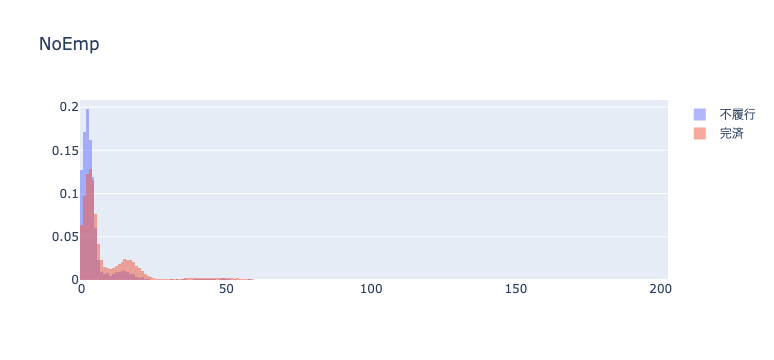

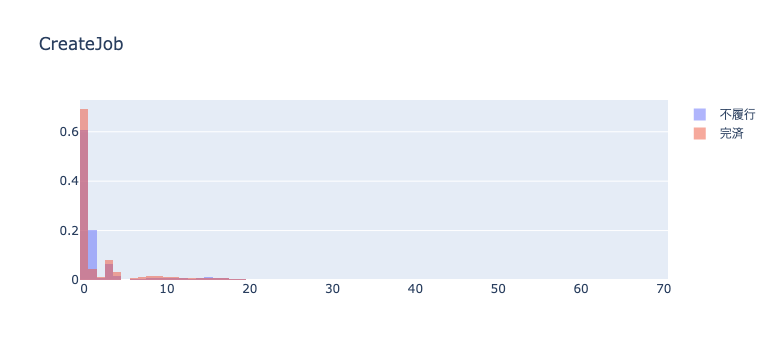

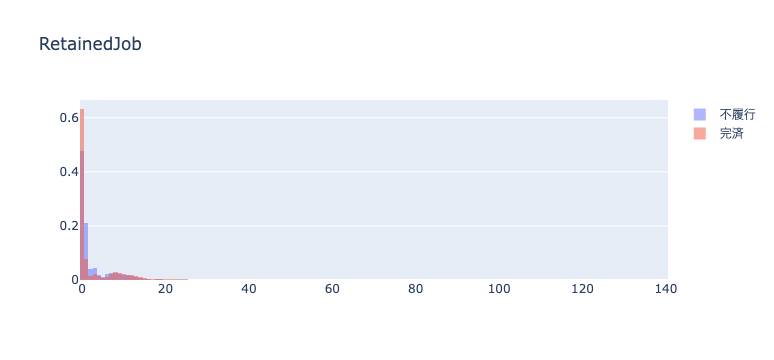

In [83]:
fig = plot_histogram(train_data, "NoEmp")
fig.show()
fig = plot_histogram(train_data, "CreateJob")
fig.show()
fig = plot_histogram(train_data, "RetainedJob")
fig.show()

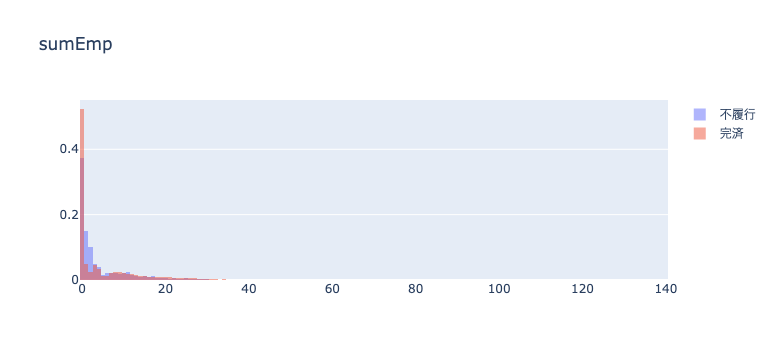

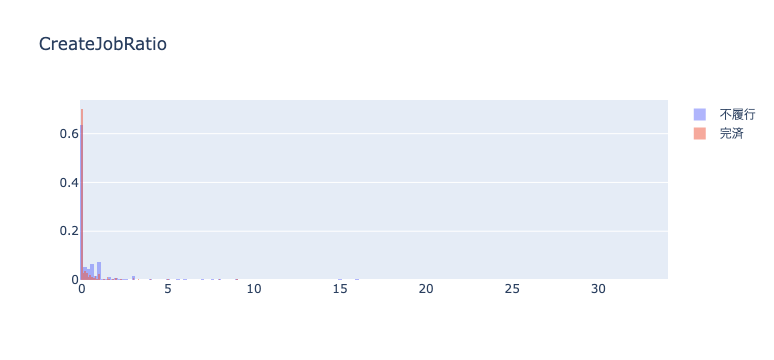

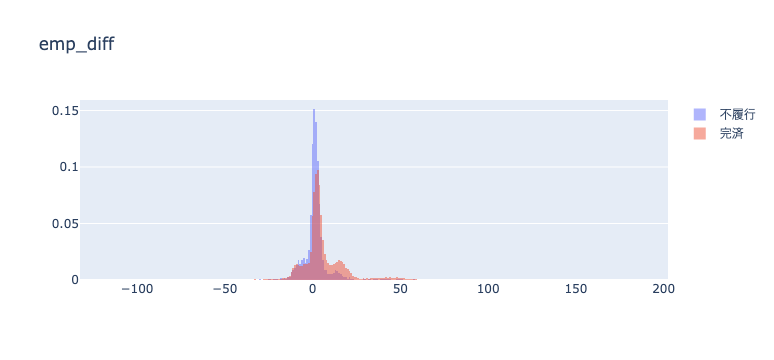

In [87]:
# 維持できる雇用者数と新規雇用者数の和
train_data["sumEmp"] = train_data["CreateJob"] + train_data["RetainedJob"]
fig = plot_histogram(train_data, "sumEmp")
fig.show()
# 融資前雇用者数に対する新規雇用者数の割合
train_data["CreateJobRatio"] = train_data["CreateJob"] / train_data["NoEmp"]
fig = plot_histogram(train_data, "CreateJobRatio")
fig.show()
# 融資前雇用者数と維持できる雇用者数の差
train_data["emp_diff"] = train_data["NoEmp"] - train_data["RetainedJob"]
fig = plot_histogram(train_data, "emp_diff")
fig.show()

### 融資額・融資期間

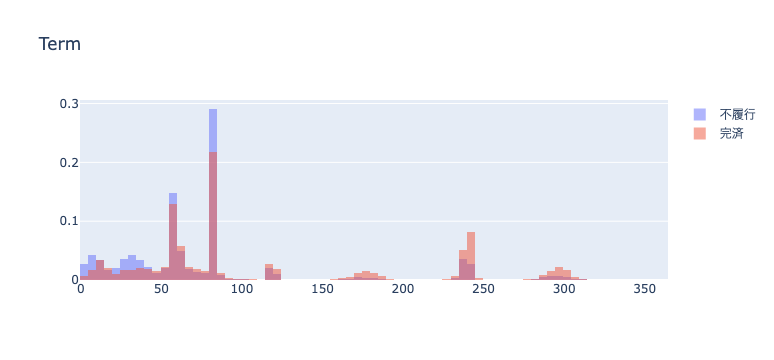

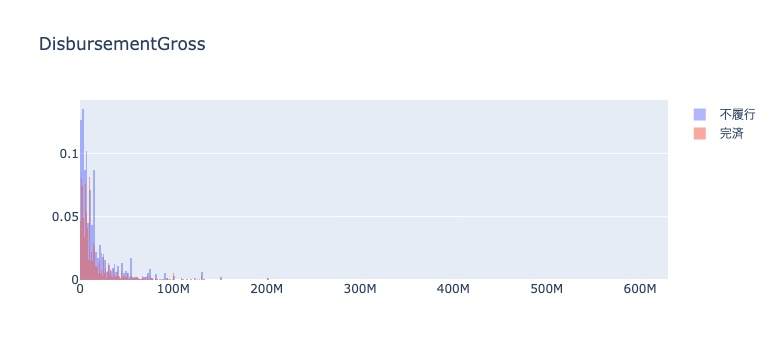

In [96]:
fig = plot_histogram(train_data, "Term")
fig.show()
fig = plot_histogram(train_data, "DisbursementGross")
fig.show()

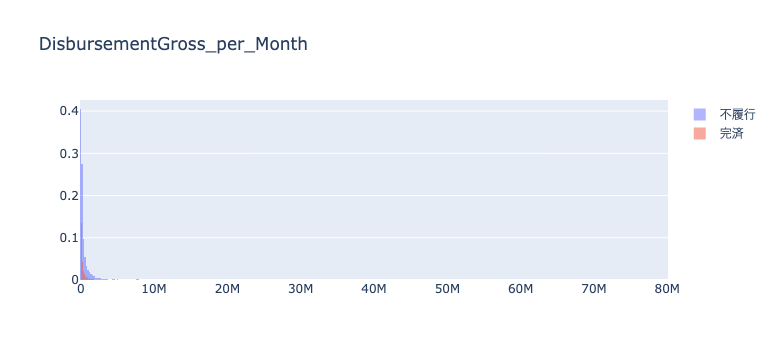

In [98]:
train_data["DisbursementGross_per_Month"] = train_data["DisbursementGross"] / train_data["Term"]
fig = plot_histogram(train_data, "DisbursementGross_per_Month")
fig.show()